<a href="https://colab.research.google.com/github/razzkoirala/devops-camp-pipeline/blob/main/LabDocument/8_Feature_Toggles_%26_Release_Patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Toggles & Release Patterns
Updated 5/17/2022

## Overview

In this lab, students will learn how to create feature toggles to control update releases using Kubernetes, Python, and HTML/Javascript.

**Estimated time:** 1 hr

Setup Needed:
* Introduction to Automated Build & Pipeline Commits







## Learning Objectives

1. Create ConfigMap in Kubernetes

2. Edit server.py to implement the feature toggle

3. Modify HTML templates

4. Verify deployment of app with locations disabled

5. Change deployments to have RollingUpdate strategy

6. Change ConfigMap to deploy new feature

7. Confirm new feature development

# Instructions

## Create ConfigMap in Kubernetes

1. Open VSCode and enter the lab environment you created in the containerization lab

2.	In the `afs-labs-student` folder, locate the `kubernetes` folder. In it, create a new file called `config-map.yaml`

  a. Copy and paste the following template to the `config-map.yaml`

In [ ]:
apiVersion: v1
kind: ConfigMap
metadata:
  name: <NAME>
  namespace: <YOUR NAMESPACE>
data:
  LOCATION_FEATURE_ENABLED: "False"

3.	Make the following edits to `config-map.yaml`:

  a.	Set the value of the `name:` field to be `feature-toggle`

  b.	Set `namespace:` to be your namespace

  c. Save your changes to the `config-map.yaml`





4.	In the `devops-camp-pipeline` folder, look for the `devops-camp-jenkinsfile`

  a.	In the "Deploy" stage of your `devops-camp-jenkinsfile`, add the following command _before_ the `kubectl set image` command:

In [ ]:
sh 'kubectl -n <YOUR NAMESPACE> apply -f ./afs-labs-student/kubernetes/config-map.yaml'

<ul>

> **Note:** This ConfigMap will control the deployment of new features in your application. When the feature toggle is set to true, that new feature will be enabled in your web app the next time the Jenkins pipeline builds.

b. Save your changes to the `devops-camp-jenkinsfile`

</ul>


5. Make sure you're in the correct directory in the integrated terminal before adding, committing, and pushing your Jenkinsfile changes to GitHub

## Edit server.py to Implement the Feature Toggle

1. In the `afs-labs-student` folder, look for the file `server.py`

  a.	In `server.py`, navigate to line 220 which begins with `@app.route('/cart')`

2.	Change the code block's return statement on line 225 to: 

In [ ]:
return render_template("cart.html", flag=os.environ["LOCATION_FEATURE_ENABLED"])

<ul>

> **Note:** We are sending the toggle value to the `cart.html` template so that we can use that value as a variable later.

</ul>

3.	Navigate to line 212 which begins with `@app.route('/locations')`

4.	Replace the return statement and the line above it (lines 216-217) with the following code snippet:


In [ ]:
if os.environ["LOCATION_FEATURE_ENABLED"] == "True":
        pickups = db.session.query(Pickup).filter(Pickup.pickup_id > 1).all()
        return render_template("locations.html", pickups=pickups)
    else:
        return render_template("coming-soon.html")

<ul>

> **Note:** This will ensure that the location page doesn’t show if the flag is turned off, and will instead redirect to a "coming soon" page.

</ul>

5. Save your changes to `server.py`

## Modify HTML Templates

1.	In the `afs-labs-student` folder, look for the `templates` folder 

2. In `cart.html`, identify the part of the code that offers customers the option to pick up their groceries

  > **Note:** Since we are disabling the location feature, grocery pickups should not be available either.

  > **Tip:** You can CTRL+F in `cart.html` to search for lines in the code that involve “pickup” or "location"

  a.	Above line 50, insert: 
  ```
  {% if flag=="True" %}
  ```


3. Under the <code>{% endraw %}</code> around line 92, add the <code>else</code> block below.

In [ ]:
{% else %}
	{% raw %}
	    <form name="deliveryOptions" ng-controller="FormController as formCtrl" ng-submit="deliveryOptions.$valid && validateDelivery()" novalidate>
        <label>Delivery is a flat $5 fee</label><br>
        <div>
          <div ng-if="customer.street_address">
              <input type="radio" name="which_address" value="my_address" ng-model="deliveryForm.which_address">Use the address I have on file:<br>
              <p>{{ customer.street_address }}<br>
              {{ customer.zipcode }} {{ customer.state }}</p>
              <input type="radio" name="which_address" value="new_address" ng-model="deliveryForm.which_address">Enter new address<br>
              <div ng-switch="deliveryForm.which_address">
            <div ng-switch-when="new_address">
                <input type="text" name="address" ng-model="deliveryForm.address" placeholder="80 Market St"><br>
                <input type="text" name="zipcode" ng-model="deliveryForm.zipcode" placeholder="94105">
                <input type="text" name="state" ng-model="deliveryForm.state" placeholder="CA" maxlength="2" size="2"><br>
            </div>
              </div>
          </div>
          <div ng-if="!customer.street_address">
          <label>Add Delivery Address</label><br>
          <input type="text" name="address" ng-model="deliveryForm.address" placeholder="80 Market St"><br>
          <input type="text" name="zipcode" ng-model="deliveryForm.zipcode" placeholder="94105">
          <input type="text" name="state" ng-model="deliveryForm.state" placeholder="CA" maxlength="2" size="2"><br>
          </div>
        </div>
        <br><label>Order Total: {{ deliveryForm.delivery==="delivery" ? cartPrice + 5 : cartPrice | currency }}</label><br>
        <input type="submit" class="btn btn-default checkout" value="Check Out"><br><br>
        <small>Please log in before placing your order. Not a member? <a href="/register">Register now!</a></small> 
        </form>
	{% endraw %}
{% endif %}


<ul>

> **Explanation of code:** 
>
> The point of this `if-else` statement is to differentiate between when the feature toggle flag is set to `true` or `false`. If the flag is `true`, then we display both the pickup and delivery options. If the flag is `false`, we only display the delivery option.

</ul>

4.  Save your changes to `cart.html`

## Change ConfigMap to Deploy Toggled Feature

1. In the `afs-labs-student` folder, look for the `kubernetes` folder and modify your `app-deployment.yaml`

2. Put this code snippet underneath `envFrom:` line (before the `- secretRef`):

In [ ]:
  - configMapRef:
            name: feature-toggle

<ul>

> **Tip:** Make sure this line has the same number of leading spaces as the `secretRef:` line

</ul>

3. Save your changes to `app-deployment.yaml`

4.	In your terminal, apply the new changes by running 
```
kubectl -n <YOUR NAMESPACE> apply -f <PATH TO app-deployment.yaml> 
```

  a.	You’ll need to do this any time you make a change to your YAML files

5.	Add, commit, and push all your changes in `afs-labs-student` to trigger a new build in Jenkins
  
  a.	`git add .`
  
  b.	`git commit -m "add feature toggles"`
  
  c.	`git push`


## Verify Deployment of App

1.	Navigate to your web application in your browser and go to the Locations tab at the top
2.	This page should say “This feature is in development and coming soon to the site” since the flag is set to “False”

  a.	If you click shopping cart icon on the top right corner, you’ll see that the only option for items is Delivery 

3.	Now change the value of `LOCATION_FEATURE_ENABLED` to “True” in `config-map.yaml`

4.	In your terminal, apply your changes by running 
```
kubectl -n <YOUR NAMESPACE> apply -f <PATH TO app-deployment.yaml>
``` 

5.	Commit and push your changes to trigger a new pipeline build

6. Once the build finishes successfully, reload the website. The Locations page should display a list of information, and the shopping cart page should show Pickup as an option


## Change Deployments to have RollingUpdate Strategy

1. In VSCode, in the `afs-labs-student/kubernetes` folder, find and open your `app-deployment.yaml`

2.	Change the `type:` from `Recreate` to `RollingUpdate` 

3.	Put this code snippet directly underneath `type:` 

In [ ]:
rollingUpdate:
      maxSurge: 1
      maxUnavailable: 0

<ul>

> **Tip:** _Ensure_ `rollingUpdate:` has the same number of leading spaces as `type:`
>
> VSCode should auto-indent this for you, but it doesn't hurt to double check.

> **Note:** The RollingUpdate strategy will make it so new pods will be deployed alongside old pods and then traffic is swapped over before deletion of the old pods. This allows for updates to your app with no downtime for the user.

</ul>

4.	Repeat steps 1-3 in `db-deployment.yaml`

5.	In the VSCode terminal, make sure you're in the `afs-labs-student/kubernetes` folder before applying your changes by running 
```
kubectl -n <YOUR NAMESPACE> apply -f ./
``` 

6. Commit and push your changes to GitHub


## Confirm RollingUpdate Strategy

1. Check the logged events and information about your deployment by running the following terminal command:
```
kubectl describe deploy app-deployment -n <YOUR NAMESPACE>
```

 a. Confirm that your application deployed using the `RollingUpdate` strategy.

<figure>
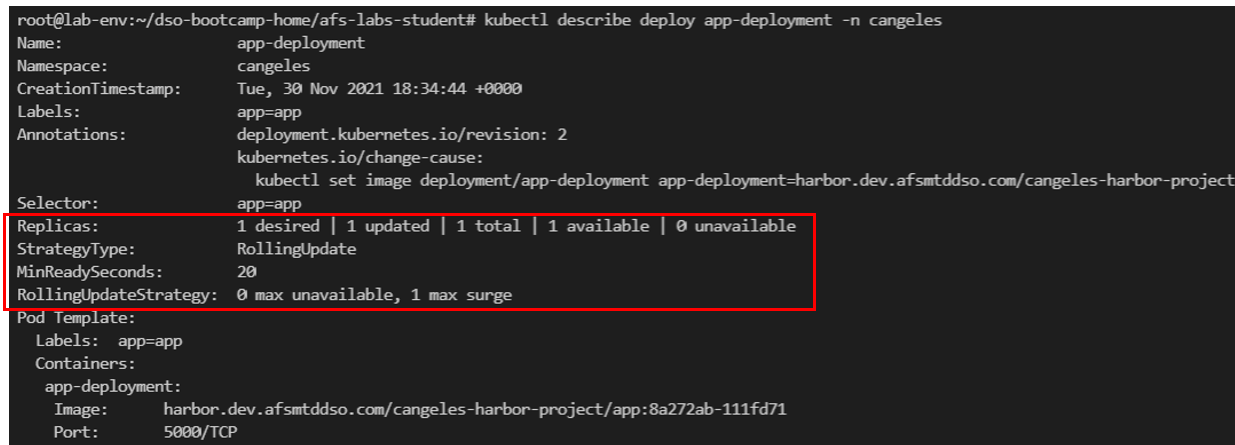
</figure>

<ul>

 b. Scroll down and look for "ScalingReplicaSet" under the "Reason" column of the "Events"

 > **Tip:** It may take a minute for your rolling update to complete and not show all of the events.

c. Verify that the pods in the replica set are scaled up and down.

 </ul>

<figure>
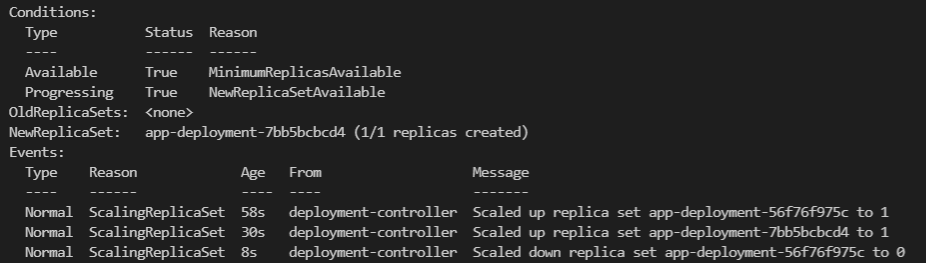
</figure>

<ul>

> **Explanation:**
>
> In the example image above, examine the timestamps under the "Age" column of each event.
>
> Notice how the new deployment replica set (i.e., `app-deployment-7bb5bcbcd4`) is created/"scaled up" _before_ the old replica set (i.e., `app-deployment-56f76f975c`) is taken down/"scaled down." 
> 
> As mentioned earlier, the RollingUpdate strategy allows for updates to your application with no downtime for the user.
>
> If we had a Recreate strategy, we'd see that the pods are only spun up _after_ they're taken down, which would result in downtime between when we update the app and when we see the changes reflected on the site.

</ul>

## You're done if...

1. Both your pods are running and there are no errors in your logs

2. Your website displays all the expected features

3. Changing the feature toggle to "True" and rebuilding successfully allows you to see the "Locations" page AND the option to pickup your groceries on the cart page (see the two images below)

4. Changing the feature toggle to "False" and rebuilding successfully disables the "Locations" page and removes the pickup option on the cart page

5. Post a screen shot of your Jenkins pipeline to the main class chat group, all stages should be displaying green and please make sure to include the title so we can see your student number e.g. "Pipeline student01..." If you were not able to complete the labs during the class and can no longer post to the chat group, please email them to afs.agile.institute@accenturefederal.com.

6. Please post two screen shots of your Farm to Front Door app, one with the toogle on and one with the toggle off, like the below examples. Make to capture the url bar in your screen shot so we can identify who it's coming from. These screen shots along with the Jenkins screen shot above will be used to document completion of the labs for this course and for your eligibility to earn the ICP-IDO certification. 



<figure>
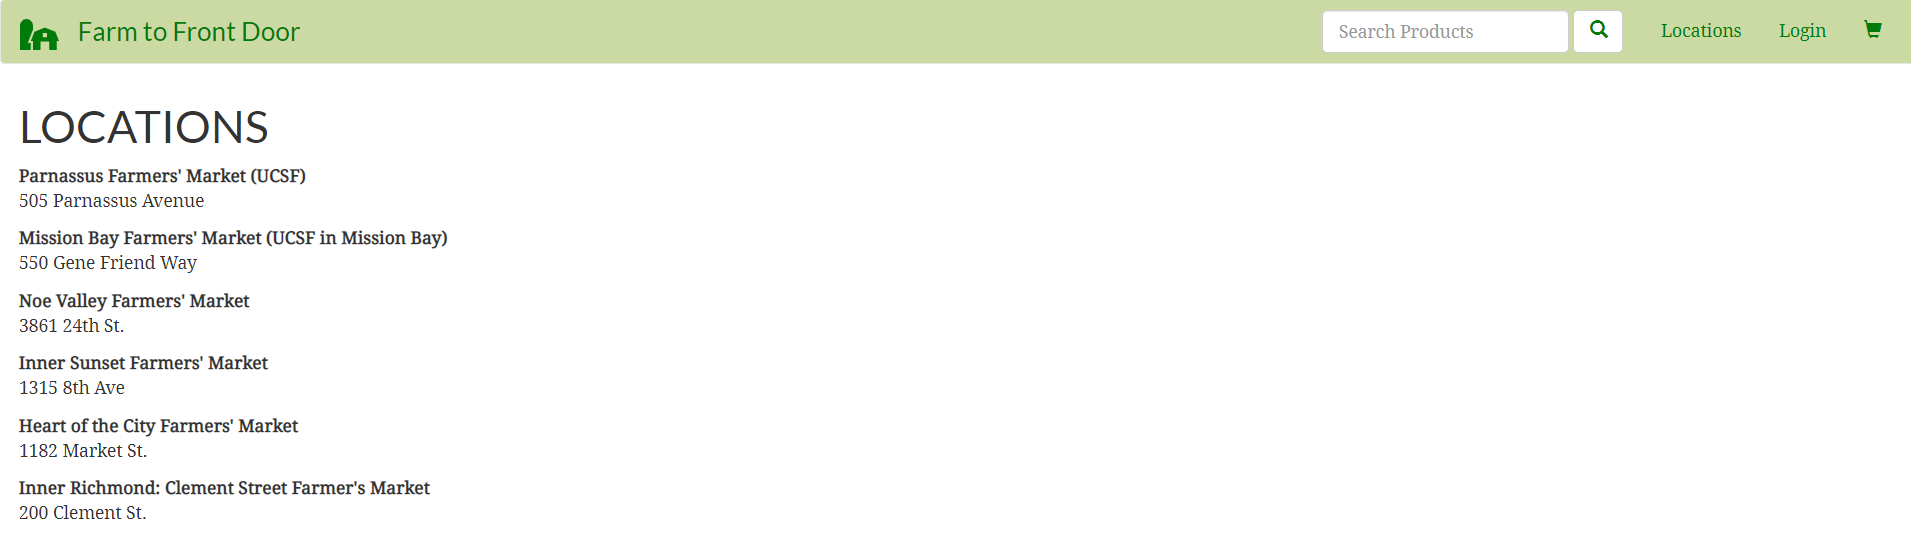
</figure>

<figure>
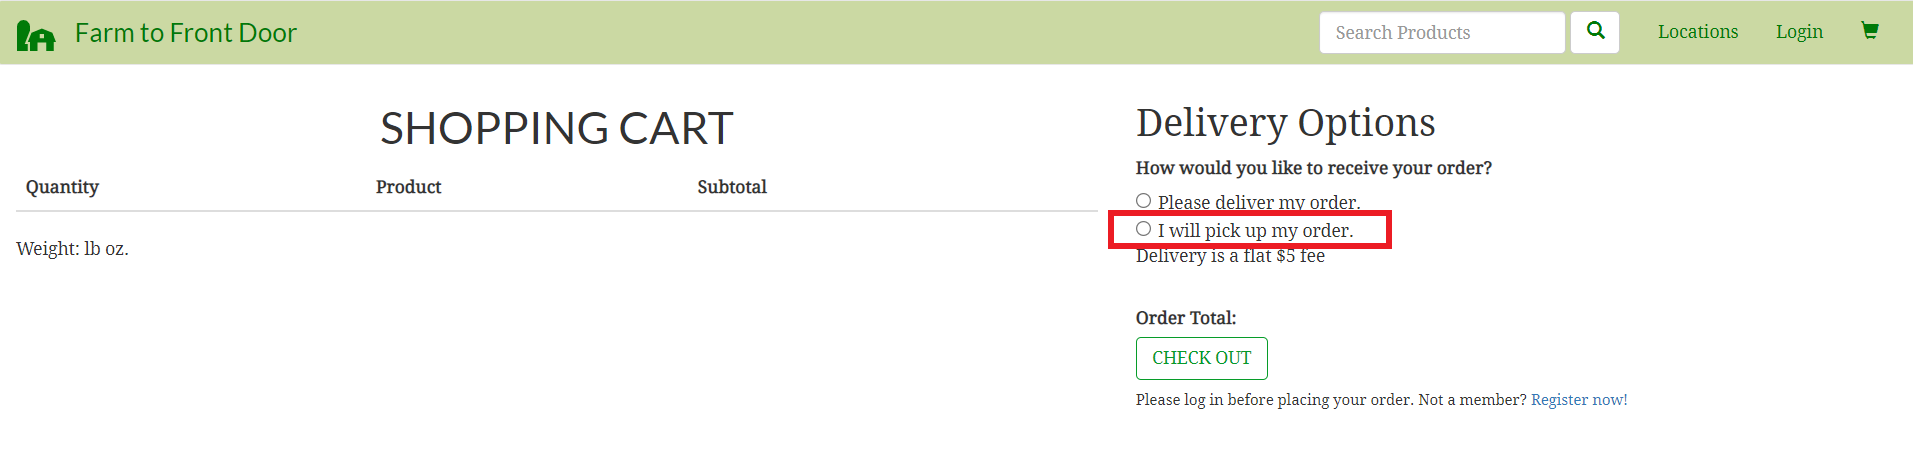
</figure>

# Appendix

Sample files of what your files should look like after this lab are available at: https://github.com/khaledAFS/sample-files/tree/main/post-feature-toggles